<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyzing-Data-from-Basileus'-Generation-Setting-Experiment" data-toc-modified-id="Analyzing-Data-from-Basileus'-Generation-Setting-Experiment-1">Analyzing Data from Basileus' Generation Setting Experiment</a></span><ul class="toc-item"><li><span><a href="#Variables-in-the-dataset" data-toc-modified-id="Variables-in-the-dataset-1.1">Variables in the dataset</a></span></li><li><span><a href="#Reading-in-the-data" data-toc-modified-id="Reading-in-the-data-1.2">Reading in the data</a></span></li><li><span><a href="#Visual-data-inspection" data-toc-modified-id="Visual-data-inspection-1.3">Visual data inspection</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-target-variables" data-toc-modified-id="Distribution-of-target-variables-1.3.1">Distribution of target variables</a></span></li><li><span><a href="#Relationships-between-variables" data-toc-modified-id="Relationships-between-variables-1.3.2">Relationships between variables</a></span></li></ul></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-1.4">Correlations</a></span></li><li><span><a href="#Regression-Analysis" data-toc-modified-id="Regression-Analysis-1.5">Regression Analysis</a></span><ul class="toc-item"><li><span><a href="#Randomness-predicting-Grammar/Style/Spelling" data-toc-modified-id="Randomness-predicting-Grammar/Style/Spelling-1.5.1">Randomness predicting Grammar/Style/Spelling</a></span></li><li><span><a href="#Randomness-predicting-Readability-Grade" data-toc-modified-id="Randomness-predicting-Readability-Grade-1.5.2">Randomness predicting Readability Grade</a></span><ul class="toc-item"><li><span><a href="#Regression-diagnostics-(checking-assumptions)" data-toc-modified-id="Regression-diagnostics-(checking-assumptions)-1.5.2.1">Regression diagnostics (checking assumptions)</a></span></li></ul></li><li><span><a href="#Presentation-of-Regression" data-toc-modified-id="Presentation-of-Regression-1.5.3">Presentation of Regression</a></span></li><li><span><a href="#Randomness-predicting-Glue-Index" data-toc-modified-id="Randomness-predicting-Glue-Index-1.5.4">Randomness predicting Glue Index</a></span></li></ul></li></ul></li></ul></div>

# Analyzing Data from Basileus' Generation Setting Experiment

*Put stuff here explaining on the methodology ("what was done")...*

Data can be obtained [here](https://docs.google.com/spreadsheets/d/1a-oHJdBUvwTUam7Y9U9vqEvrcd4fK2q3oqm3H4iI4G0/edit#gid=116999801)

## Variables in the dataset

Variable|Meaning|Target
-|-|-
Randomness|Generator Setting|Dependent Variable
Grammar/Style/Spelling|Your writing can have no spelling or grammar mistakes but still be awkward, clumsy, and hard to read. Style can make your writing easier and more enjoyable to read. Style covers issues like repeated sentence starts, clunky word order and phrasing, hidden verbs, and more.|Higher is better
Readability Grade|A readability score is a measure of how easy your text is to read. Your readability score shows what grade level of students could understand and engage with your writing. For instance, a score of 7 means that seventh-grade students could read your work.|Lower is better
Glue Index|Glue words are words that are common, low-quality, or nondescript, and too many of them can make your sentences "sticky". Sticky sentences slow your reader down; try to avoid them.|Lower is better

## Reading in the data

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression as linreg
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate, KFold
import statsmodels.api as sm

# Read in data of the GSheet document (only 1 minute tab now)
nai = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1a-oHJdBUvwTUam7Y9U9vqEvrcd4fK2q3oqm3H4iI4G0/export?format=csv&gid=1831608934', header=1)

print(nai.iloc[:,:15].head(3))
print(nai.iloc[:,15:].head(3))

   Randomness  Max Length  Min Length  Top-K  Nucleus Tail-Free  Penalty  \
0         0.6          40          20     60      0.9  disabled      2.8   
1         0.6          40          20     60      0.9  disabled      2.8   
2         0.6          40          20     60      0.9  disabled      2.8   

   Range  Slope                                                Raw  Goals  \
0    512   3.33  The colony's central courtyard was a vast expa...    NaN   
1    512   3.33  The hallways were empty save for a few people ...    NaN   
2    512   3.33  The corridor outside the dormitory was narrow,...    NaN   

   Improvements Grammar/Style/Spelling  Sentence Length  Readability Grade  
0           NaN                    74%              NaN                  5  
1           NaN                    77%              NaN                  5  
2           NaN                    65%              NaN                  6  
   Sentence Variety  Passive Voice  Complex Paragraphs  Conjunction Starts  \


In [19]:
# drop columns without data (and data without variance)
nai = nai[["Randomness", "Raw", "Grammar/Style/Spelling", "Readability Grade", "Glue Index"]]

print("First 5 lines of data:\n")
print(nai.head(5))
print("\Dataframe Info:\n")
print(nai.info())

First 5 lines of data:

   Randomness                                                Raw  \
0         0.6  The colony's central courtyard was a vast expa...   
1         0.6  The hallways were empty save for a few people ...   
2         0.6  The corridor outside the dormitory was narrow,...   
3         0.6  The dormitory halls were quiet, the colonists ...   
4         0.6  The corridor outside her room was empty except...   

  Grammar/Style/Spelling  Readability Grade Glue Index  
0                    74%                  5        44%  
1                    77%                  5        47%  
2                    65%                  6        46%  
3                    83%                  4        41%  
4                    91%                  8        43%  
\Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  

In [20]:
# Convert % strings to float
nai[["Grammar/Style/Spelling", "Glue Index"]] = nai[["Grammar/Style/Spelling", "Glue Index"]].astype(str).replace({"\%":""}, regex=True).astype(float)
nai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Randomness              90 non-null     float64
 1   Raw                     90 non-null     object 
 2   Grammar/Style/Spelling  90 non-null     float64
 3   Readability Grade       90 non-null     int64  
 4   Glue Index              90 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.6+ KB


## Visual data inspection

A few scatter plot with lowess lines to see if we are dealing with linear relationships. I'd actually expect something more like a curvilinear relationship.

### Distribution of target variables

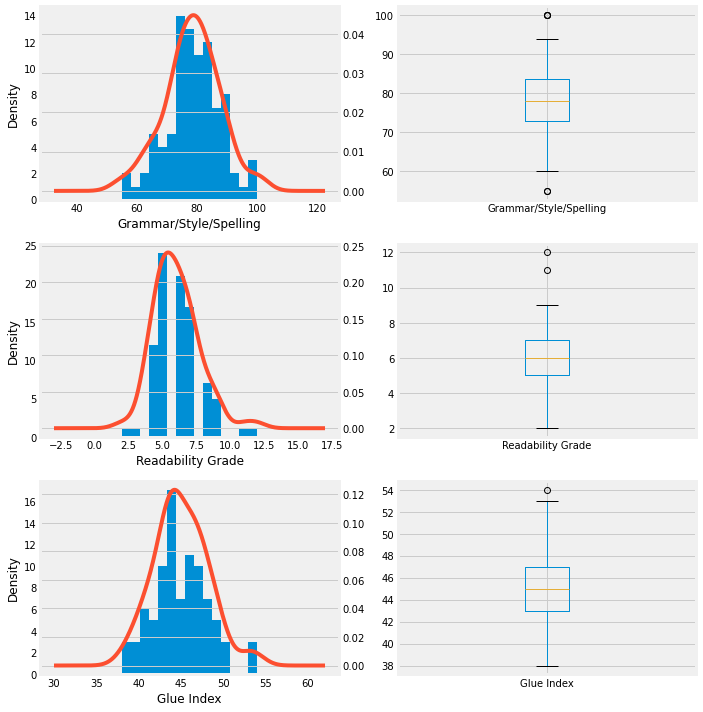

In [21]:
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize = (10,10))

# Histograms with KDE
ax1 = nai["Grammar/Style/Spelling"].plot.hist(ax = axes[0,0], bins = 15)
ax1.set_xlabel("Grammar/Style/Spelling")
nai["Grammar/Style/Spelling"].plot.kde(ax = axes[0,0], secondary_y=True)

ax2 = nai["Readability Grade"].plot.hist(ax = axes[1,0], bins = 15)
ax2.set_xlabel("Readability Grade")
nai["Readability Grade"].plot.kde(ax = axes[1,0], secondary_y=True)

ax3 = nai["Glue Index"].plot.hist(ax = axes[2,0], bins = 15)
nai["Glue Index"].plot.kde(ax = axes[2,0], secondary_y=True)
ax3.set_xlabel("Glue Index")


# Boxplots
nai["Grammar/Style/Spelling"].plot.box(ax = axes[0,1])
nai["Readability Grade"].plot.box(ax = axes[1,1])
nai["Glue Index"].plot.box(ax = axes[2,1])

fig.tight_layout()
plt.show()

We have a few minor outliers, but nothing too much out of the ordinary that sticks out. I also would be hesitant to remove any outlier for analysis, since we in this case we can be sure, that all data points are truly part of the "population" (i.e. all potential outputs that we could have gotten with the respective setting).

### Relationships between variables

A few scatter plot with lowess lines to see if we are dealing with linear relationships. I'd actually expect something more like a curvilinear relationship.

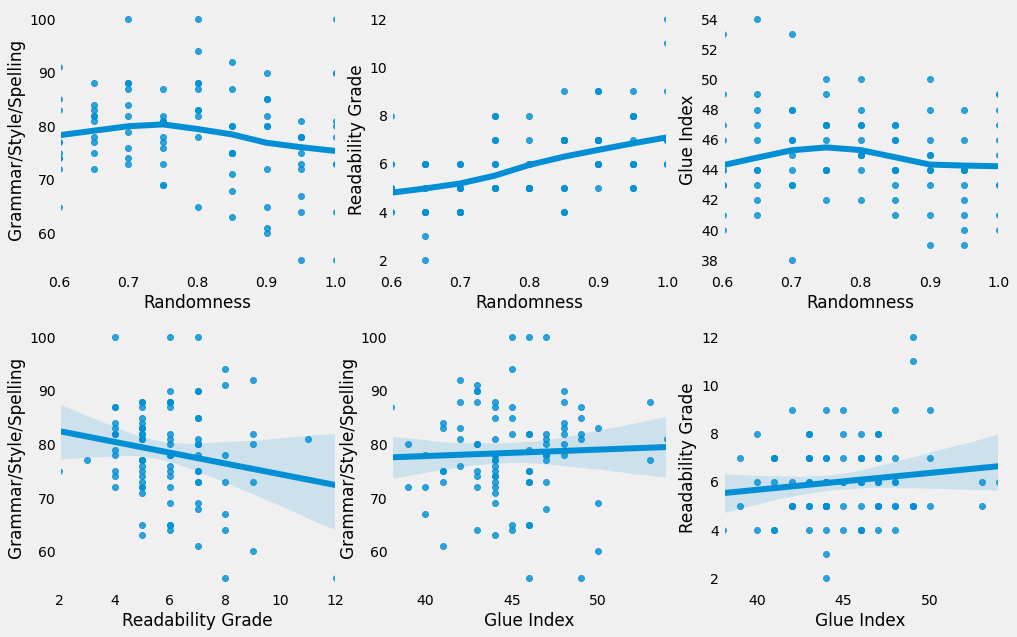

In [22]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(2, 3, figsize = (15,10))
plt.grid(False)
# Relationship with Randomness
sns.regplot(data= nai, y ="Grammar/Style/Spelling", x = "Randomness", lowess = True, ax = axes[0,0])
sns.regplot(data= nai, y ="Readability Grade", x = "Randomness", lowess = True, ax = axes[0,1])
sns.regplot(data= nai, y ="Glue Index", x = "Randomness", lowess = True, ax = axes[0,2])
# Relationships between dependent vars
sns.regplot(data= nai, y ="Grammar/Style/Spelling", x = "Readability Grade", lowess = False, ax = axes[1,0])
sns.regplot(data= nai, y ="Grammar/Style/Spelling", x = "Glue Index", lowess = False, ax = axes[1,1])
sns.regplot(data= nai, y ="Readability Grade", x = "Glue Index", lowess = False, ax = axes[1,2])

for ax in fig.axes:
    ax.grid(False)

plt.show()

Hmm interesting, the relationship with Grammar/Style/Spelling looks like a weak quadratic relationship ("reverse U"), with Readability it looks a little bit cubic (but a linear relationship might be a decent enough fit with less danger of overfitting), and Glue Index might be *more or less* quadratic.

There seems to be not much reliable relationship of any kind between the target variables (will still be looking at correlations below), so a MANOVA (which depends on a linear combination of the dependent variables) is probably out of the question.

## Correlations

In [23]:
nai[["Randomness", "Grammar/Style/Spelling", "Readability Grade", "Glue Index"]].corr()

,Randomness,Grammar/Style/Spelling,Readability Grade,Glue Index
Randomness,1.000000,-0.165109,0.552226,-0.153462
Grammar/Style/Spelling,-0.165109,1.000000,-0.184396,0.041386
Readability Grade,0.552226,-0.184396,1.000000,0.131093
Glue Index,-0.153462,0.041386,0.131093,1.000000


Best to ignore the results for correlations Randomness <-> Grammar/Style/Spelling and Randomness <-> Glue Index, since the relationship clearly is non-linear.

Otherwise:
* Strong negative linear relations between Readability and Randomness (lower is better for readability) so: the higher the randomness, the worse readability tends to be)
* The 3 target variables really have weak to none linear relationships with each other

## Regression Analysis

In [24]:
# Setting up k-fold cross validation

kf = KFold(5, shuffle=True, random_state=42)


# Adding quadratic and cubic terms
nai["rand**2"] = nai["Randomness"]**2
nai["rand**3"] = nai["Randomness"]**3

### Randomness predicting Grammar/Style/Spelling

In [25]:
# Select best model

predictor_li = ["Randomness", "rand**2", "rand**3"]

current_predictors = []
gss_model = linreg()

for pred in predictor_li:
    current_predictors.append(pred)
    cross_val = cross_validate(gss_model, nai[current_predictors], nai["Grammar/Style/Spelling"],
                           scoring=["neg_mean_squared_error", "r2"], cv=kf)
    neg_mses = cross_val["test_neg_mean_squared_error"]
    r_squares = cross_val["test_r2"]
    avg_rmse = np.mean((neg_mses*-1)**0.5)
    avg_r_sq = np.mean(r_squares)
    print("Model performance for {} predicting Grammar/Style/Spelling:".format(', '.join(current_predictors)))
    print("r-square: {:.4f}    RMSE: {:.2f}\n".format(avg_r_sq, avg_rmse))

Model performance for Randomness predicting Grammar/Style/Spelling:
r-square: -0.0441    RMSE: 9.06

Model performance for Randomness, rand**2 predicting Grammar/Style/Spelling:
r-square: -0.0447    RMSE: 9.05

Model performance for Randomness, rand**2, rand**3 predicting Grammar/Style/Spelling:
r-square: -0.0710    RMSE: 9.11



These model performances are all so terrible, that I would not bother to investigate further - there is just no relationship there.

### Randomness predicting Readability Grade

In [26]:
# Select best model

predictor_li = ["Randomness", "rand**2", "rand**3"]

current_predictors = []
rg_model = linreg()

for pred in predictor_li:
    current_predictors.append(pred)
    cross_val = cross_validate(rg_model, nai[current_predictors], nai["Readability Grade"],
                           scoring=["neg_mean_squared_error", "r2"], cv=kf)
    neg_mses = cross_val["test_neg_mean_squared_error"]
    r_squares = cross_val["test_r2"]
    avg_rmse = np.mean((neg_mses*-1)**0.5)
    avg_r_sq = np.mean(r_squares)
    print("Model performance for {} predicting Readability Grade:".format(', '.join(current_predictors)))
    print("r-square: {:.4f}    RMSE: {:.2f}\n".format(avg_r_sq, avg_rmse))

Model performance for Randomness predicting Readability Grade:
r-square: 0.2135    RMSE: 1.38

Model performance for Randomness, rand**2 predicting Readability Grade:
r-square: 0.1566    RMSE: 1.40

Model performance for Randomness, rand**2, rand**3 predicting Readability Grade:
r-square: 0.1487    RMSE: 1.42



This looks more promising, continuing with linear model.

#### Regression diagnostics (checking assumptions)

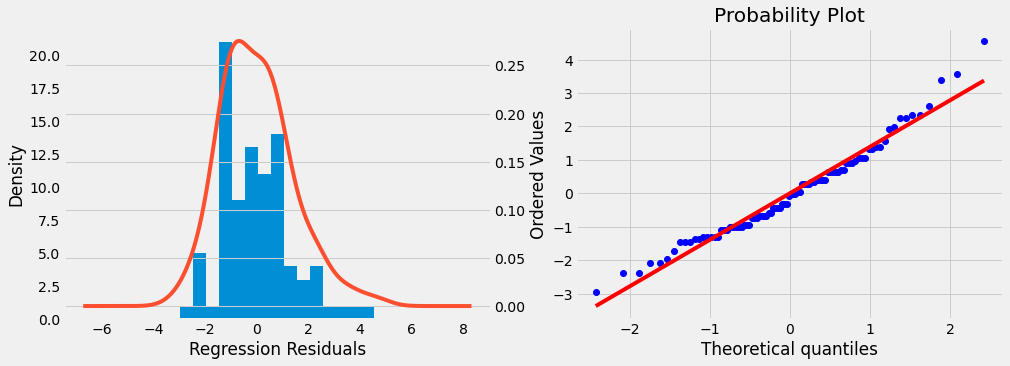

In [27]:
# Fit model and save residuals
rg_model.fit(nai[["Randomness"]], nai["Readability Grade"])

pred = rg_model.predict(nai[["Randomness"]])
obs_pred_res_df = pd.DataFrame({'Actual': nai["Readability Grade"], 'Predicted': pred})
obs_pred_res_df["Residuals"] = obs_pred_res_df['Actual'] - obs_pred_res_df['Predicted']

# Check for normal distribution of residuals with histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize = (15,5))

# Histograms with KDE
ax1 = obs_pred_res_df["Residuals"].plot.hist(ax = axes[0], bins = 15)
ax1.set_xlabel("Regression Residuals")
obs_pred_res_df["Residuals"].plot.kde(ax = axes[0], secondary_y=True)
# Q-Q Plot
stats.probplot(obs_pred_res_df["Residuals"], dist="norm", plot=axes[1])
plt.show()

Residuals are normally distributed

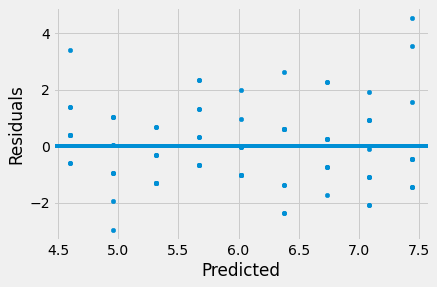

In [28]:
# Checking for Homoscedasticity

plot = obs_pred_res_df.plot.scatter(x = "Predicted", y = "Residuals")
#horiz_line_data = np.array([40 for i in xrange(len(xs))])
plt.axhline(y=0, linestyle='-')
plt.show()

Residuals seem close enough to homoscedacity - looks like assumptions for a linear regression hold!

### Presentation of Regression

                            OLS Regression Results                            
Dep. Variable:      Readability Grade   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     38.61
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           1.68e-08
Time:                        14:49:36   Log-Likelihood:                -156.94
No. Observations:                  90   AIC:                             317.9
Df Residuals:                      88   BIC:                             322.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3422      0.926      0.370      0.7

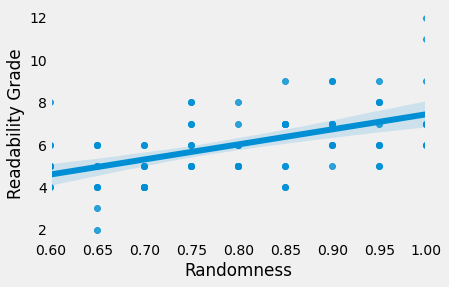

In [121]:
y = nai["Readability Grade"]
x = nai["Randomness"]
x = sm.add_constant(x)

model = sm.OLS(y,x)
res = model.fit()
print(res.summary())

# Create plot with actual values and regression line with predicted values
sns.regplot(data= nai, y ="Readability Grade", x = "Randomness")
plt.grid(False)
plt.show

# Table with randomness Values and predicted Readability
rand_range_pred = pd.DataFrame({"const": 1, "Randomness": np.arange(0.6,1.0,0.05)})
rand_range_pred["Predicted"] = res.predict(rand_range)

print("\nPredicted Values for different Randomness settings:")
print(rand_range_pred[["Randomness", "Predicted"]])

The randomness settings explains a whooping 30% of the variation of the Readability Grade. 

Remember, that the readability represents "what grade level of students could understand and engage with your writing. For instance, a score of 7 means that seventh-grade students could read your work.". 

A *lower* readability score is thus better (although arguably if it gets *too* low, the style might become a bit "primitive"? The formula for the expected readability *with everything on default setting* is:

Readability Grade = 0.34 + (7.1 * Randomness Setting)

### Randomness predicting Glue Index

In [ ]:
# Select best model

predictor_li = ["Randomness", "rand**2", "rand**3"]

current_predictors = []
gi_model = linreg()

for pred in predictor_li:
    current_predictors.append(pred)
    cross_val = cross_validate(gi_model, nai[current_predictors], nai["Glue Index"],
                           scoring=["neg_mean_squared_error", "r2"], cv=kf)
    neg_mses = cross_val["test_neg_mean_squared_error"]
    r_squares = cross_val["test_r2"]
    avg_rmse = np.mean((neg_mses*-1)**0.5)
    avg_r_sq = np.mean(r_squares)
    print("Model performance for {} predicting Glue Index:".format(', '.join(current_predictors)))
    print("r-square: {:.4f}    RMSE: {:.2f}\n".format(avg_r_sq, avg_rmse))

More abysmal model performance - will not bother to investigate further... 

In [ ]:
# save the data for people who want to use R Studio

nai.to_csv("NAI_generation_setting_exp.csv")